# Solar prediction

In [342]:
import xarray as xr
#import tensorflow as tf
#from tensorflow.keras import datasets, layers, models
#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import cartopy.crs as ccrs
import cartopy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler
from temp_clustering import cluster_temp_diff
from sklearn.model_selection import train_test_split
from Smoothed_Values import Smoothed_Temp_Solar

import ipywidgets as widgets
from ipywidgets import interact
from plot_map import plot_map
from settings import path_data, path_results

In [3]:
def smooth_butter(data, order):
    b, a = signal.butter(order, 0.125)
    y = signal.filtfilt(b, a, data)#, padlen=150)
    return y

In [4]:
ds_solar = xr.open_dataset(path_data / 'Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset(path_data / 'Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset(path_data / 'T2m_R1_ym_1stMill.nc')
ds_temp_r2 = xr.open_dataset(path_data / 'T2m_R2_ym_1stMill.nc')

In [5]:
# Dataset for Solar Forcing
df_solar = {'time':ds_solar.time.values, 'TSI':ds_solar.TSI.values.flatten()}

# Dataset for volcanic forcing
df_volc = {'time':ds_volc.time.values, 'AOD':ds_volc.AOD.values.flatten()}

# Dataset for R1
df_R1 = {'time': ds_temp_r1.time.values, 'lon':ds_temp_r1.lon.values, 'lat': ds_temp_r1.lat.values, 'T2m':ds_temp_r1.T2m.values}

# Dataset for R2
df_R2 = {'time': ds_temp_r2.time.values, 'lon':ds_temp_r2.lon.values, 'lat': ds_temp_r2.lat.values, 'T2m':ds_temp_r2.T2m.values}

In [6]:
cluster_rel = cluster_temp_diff(ds_temp_r1)

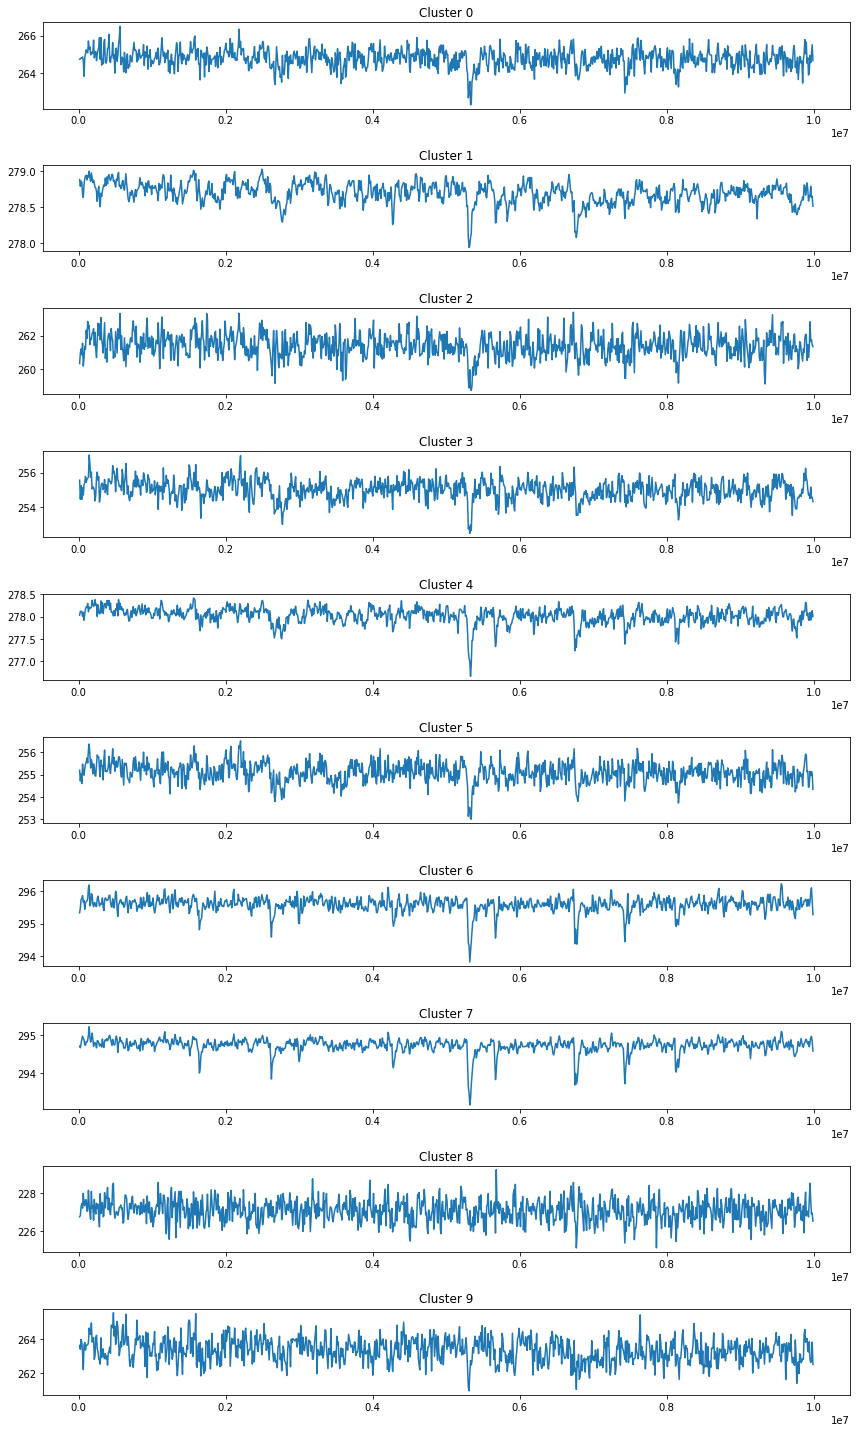

In [7]:
fig, ax = plt.subplots(np.unique(cluster_rel).shape[0], 1, figsize = (12,20))
for vals in np.unique(cluster_rel):
    ax[vals].plot(df_R1['time'], np.mean(df_R1['T2m'][:,cluster_rel == vals], axis = 1))
    ax[vals].set_title("Cluster {}".format(vals))
    
fig.tight_layout()

Cluster: 0; Pearson Correlatio coefficient = (0.05758458523808381, 0.06886493278211309)
Cluster: 1; Pearson Correlatio coefficient = (0.11696319184251601, 0.00021143577997535497)
Cluster: 2; Pearson Correlatio coefficient = (0.05798226032206588, 0.06696781726027407)
Cluster: 3; Pearson Correlatio coefficient = (0.06207481977752813, 0.049828669609434766)
Cluster: 4; Pearson Correlatio coefficient = (0.0904240486383438, 0.00423223648247398)
Cluster: 5; Pearson Correlatio coefficient = (0.06042548823535751, 0.05623375256396044)
Cluster: 6; Pearson Correlatio coefficient = (0.053877885668781086, 0.08875151423908587)
Cluster: 7; Pearson Correlatio coefficient = (0.07340166964412917, 0.020328461679165726)
Cluster: 8; Pearson Correlatio coefficient = (0.016348322145648672, 0.6057787328879551)
Cluster: 9; Pearson Correlatio coefficient = (0.07502742808881814, 0.017703413155311352)


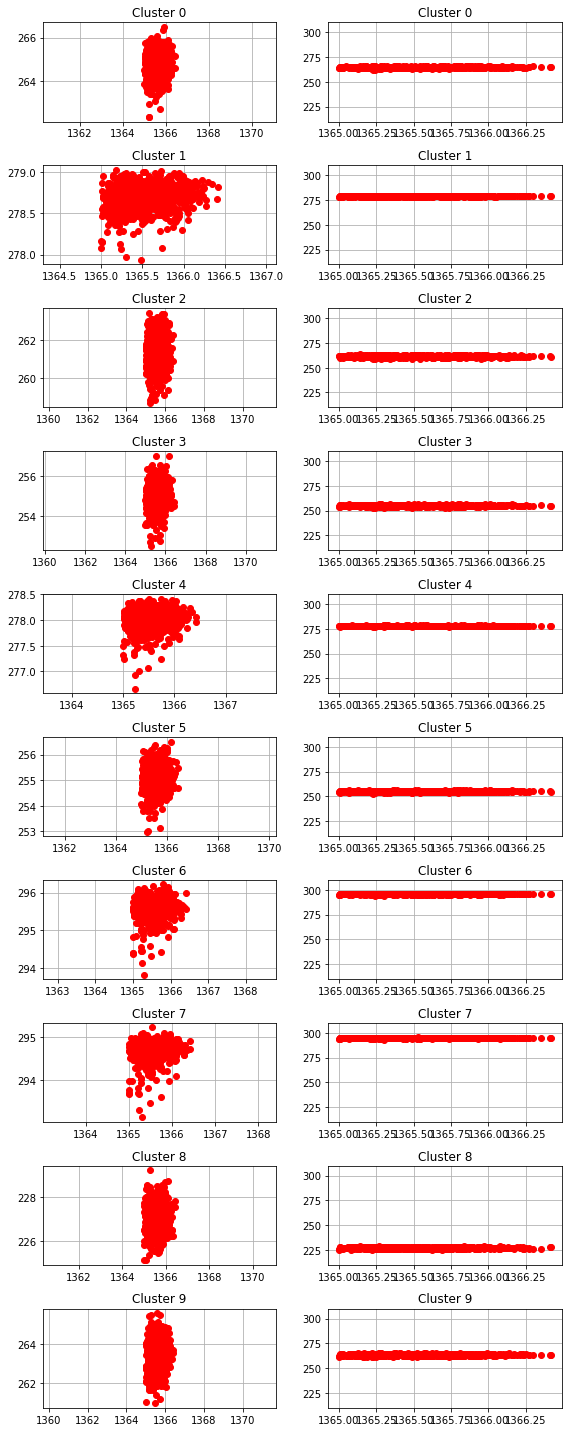

In [8]:
fig, ax = plt.subplots(np.unique(cluster_rel).shape[0], 2, figsize = (8,20))
for vals in np.unique(cluster_rel):
    ax[vals,0].plot(df_solar['TSI'], np.mean(df_R1['T2m'][:,cluster_rel == vals], axis = 1), 'or')
    ax[vals,0].set_title("Cluster {}".format(vals))
    ax[vals,0].set_ylim((210,310))
    ax[vals,0].grid()
    ax[vals,0].axis('equal')
    
    ax[vals,1].plot(df_solar['TSI'], np.mean(df_R1['T2m'][:,cluster_rel == vals], axis = 1), 'or')
    ax[vals,1].set_title("Cluster {}".format(vals))
    ax[vals,1].set_ylim((210,310))
    ax[vals,1].grid()
    
    print("Cluster: {}; Pearson Correlatio coefficient = {}"
          .format(vals,stats.pearsonr(df_solar['TSI'], np.mean(df_R1['T2m'][:,cluster_rel == vals], axis = 1))))
fig.tight_layout()

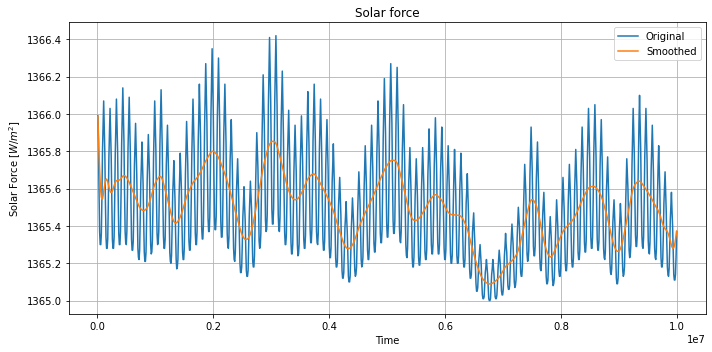

In [344]:
clust = 8
fig, ax = plt.subplots(1,1,figsize=(10,5))
#ax[0].plot(df_R1['time'], np.mean(df_R1['T2m'][:,cluster_rel == clust], axis = 1), label = 'Origianl')
#ax[0].plot(df_R1['time'], smooth_butter(np.mean(df_R1['T2m'][:,cluster_rel == clust], axis = 1),2), label = 'Smoothed')
#ax[0].set_title('Cluster result - Cluster 8')
#ax[0].set_ylabel('Temperature [K]')

ax.plot(df_solar['time'], df_solar['TSI'], label = 'Original')
ax.plot(df_solar['time'], smooth_butter(df_solar['TSI'],clust), label = 'Smoothed')
ax.set_title('Solar force')
ax.set_ylabel(r'Solar Force $[W/m^2]$')
ax.grid()
ax.legend();
ax.set_xlabel('Time')

#for a in ax:
#    a.grid()
#    a.legend();
#    a.set_xlabel('Time')
fig.tight_layout()
fig.savefig('../results/Smoothed_solar_force.png', dpi=300, bbox_inches='tight')

In [14]:
def get_pears(Temperature, Solar):

    pears_coeff_smooth = np.zeros(shape = (Temperature.shape[1], Temperature.shape[2]))
    pears_coeff = np.zeros(shape = (Temperature.shape[1], Temperature.shape[2]))
    pears_coeff_doubleSmooth = np.zeros(shape = (Temperature.shape[1], Temperature.shape[2]))


    smooth_solar = smooth_butter(Solar,8)
    for i in range(Temperature.shape[1]):
        for j in range(Temperature.shape[2]):
            pears_coeff_smooth[i,j] = stats.pearsonr(Temperature[:,i,j], smooth_solar)[0]
            pears_coeff[i,j] = stats.pearsonr(Temperature[:,i,j], Solar)[0]
            pears_coeff_doubleSmooth[i,j] = stats.pearsonr(smooth_butter(Temperature[:,i,j],8), smooth_solar)[0]
    return pears_coeff, pears_coeff_smooth, pears_coeff_doubleSmooth

In [15]:
###############
## Split the dataset and return the pearson coefficient maps
x_train1, x_test1, y_train1, y_test1 = train_test_split(df_R1['T2m'], df_solar['TSI'], test_size=0.3, random_state=42,
                                                       shuffle = False)
pears_coeff_train, pears_coeff_smooth_train, pears_coeff_doubleSmooth_train = get_pears(x_train1, y_train1)
pears_coeff_test, pears_coeff_smooth_test, pears_coeff_doubleSmooth_test = get_pears(x_test1, y_test1)
pears_coeff_full, pears_coeff_smooth_full, pears_coeff_doubleSmooth_full = get_pears(df_R1['T2m'], df_solar['TSI'])
#pears_coeff, pears_coeff_smooth, pears_coeff_doubleSmooth = get_pears(df_R1['T2m'], df_solar['TSI'])

In [16]:
def Visualize_pears_coeff(pears_coeff, pears_coeff_smooth, pears_coeff_doubleSmooth):
    lats = df_R1['lat'][:]
    lons = df_R1['lon'][:]
    smooth_solar = smooth_butter(df_solar['TSI'],8)

    f = plt.figure(figsize=(15,12))
    #######################################################
    ## Pearson no smooth
    ax = f.add_subplot(321, projection=ccrs.PlateCarree())
    pos1 = ax.contourf(lons, lats,pears_coeff,transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title('Pearson No smooth - Max R = {:.4f}'.format(np.max(pears_coeff.flatten())))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Lattitude')

    ax1 = f.add_subplot(322)
    ax1.plot(df_R1['T2m'].reshape(-1, 96*192)[:,np.argmax(pears_coeff.flatten())], df_solar['TSI'], 'or')
    ax1.axis('equal')
    ax1.grid()
    ax1.set_title('Pearson No smooth - Max Correlation value')
    ax1.set_xlabel('Temperature [K]')
    ax1.set_ylabel(r'Solar Force $[W/m^2]$')

    #######################################################
    ## Pearson SOlar Smoothed
    ax3 = f.add_subplot(323, projection=ccrs.PlateCarree())
    pos2 = ax3.contourf(lons, lats, pears_coeff_smooth,transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
    ax3.coastlines()
    ax3.set_title('Pearson Solar smoothed - Max R = {:.4f}'.format(np.max(pears_coeff_smooth.flatten())))
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Lattitude')

    ax4 = f.add_subplot(324)
    ax4.plot(df_R1['T2m'].reshape(-1, 96*192)[:,np.argmax(pears_coeff_smooth.flatten())], smooth_solar, 'or')
    ax4.axis('equal')
    ax4.grid()
    ax4.set_title('Pearson Solar smoothed - Max Correlation value')
    ax4.set_xlabel('Temperature [K]')
    ax4.set_ylabel(r'Solar Force $[W/m^2]$')

    #######################################################
    ## Pearson SOlar and Temperature Smoothed
    ax5 = f.add_subplot(325, projection=ccrs.PlateCarree())
    pos3 = ax5.contourf(lons, lats,pears_coeff_doubleSmooth,transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
    ax5.coastlines()
    ax5.set_title('Pearson Solar & Temperature smoothed - Max R = {:.4f}'.format(np.max(pears_coeff_doubleSmooth.flatten())))
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Lattitude')

    ax6 = f.add_subplot(326)
    ax6.plot(df_R1['T2m'].reshape(-1, 96*192)[:,np.argmax(pears_coeff_doubleSmooth.flatten())], smooth_solar, 'or')
    ax6.axis('equal')
    ax6.grid()
    ax6.set_title('Pearson Solar & Temperature smoothed - Max Correlation value')
    ax6.set_xlabel('Temperature [K]')
    ax6.set_ylabel(r'Solar Force $[W/m^2]$')


    f.colorbar(pos1, ax = ax)
    f.colorbar(pos2, ax = ax3)
    f.colorbar(pos3, ax = ax5)
    f.tight_layout();

c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


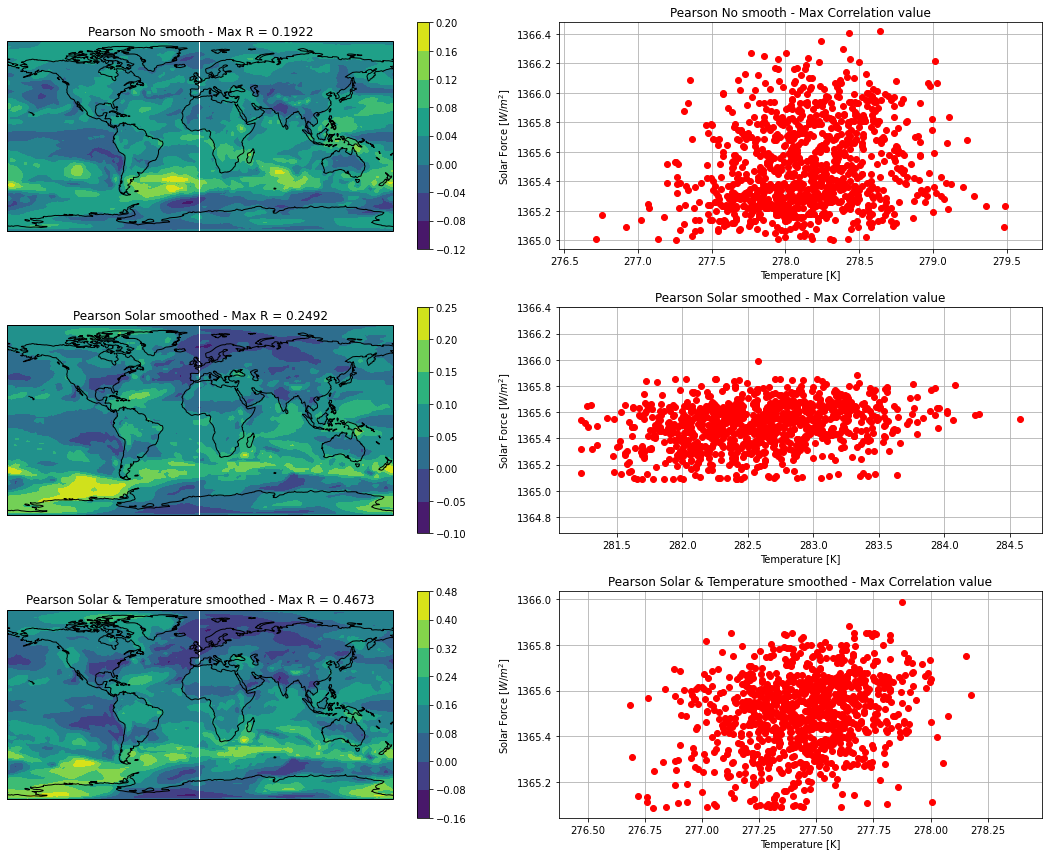

In [54]:
Visualize_pears_coeff(pears_coeff_full, pears_coeff_smooth_full, pears_coeff_doubleSmooth_full)

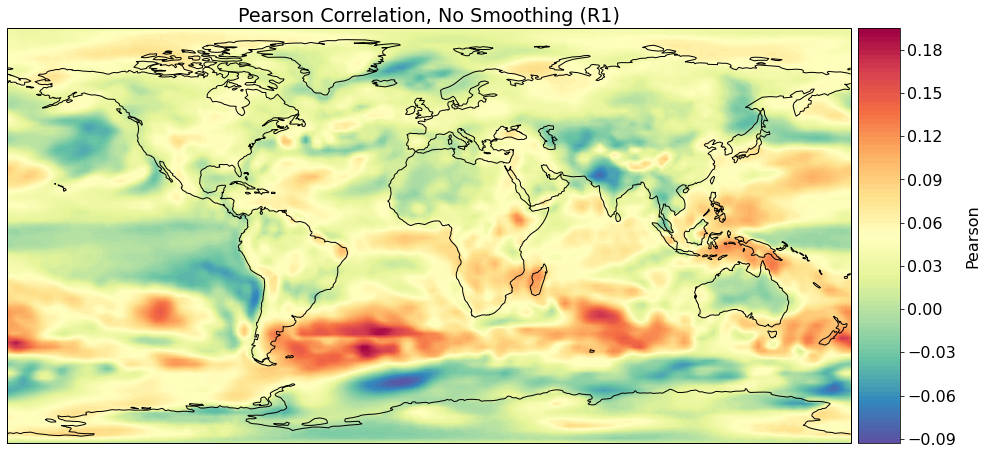

In [18]:
fig = plot_map(pears_coeff_full, title='Pearson Correlation, No Smoothing (R1)', colorbar_title='Pearson')
fig.savefig(path_results / 'map_smoothing_none.png', dpi=300, bbox_inches='tight')
fig

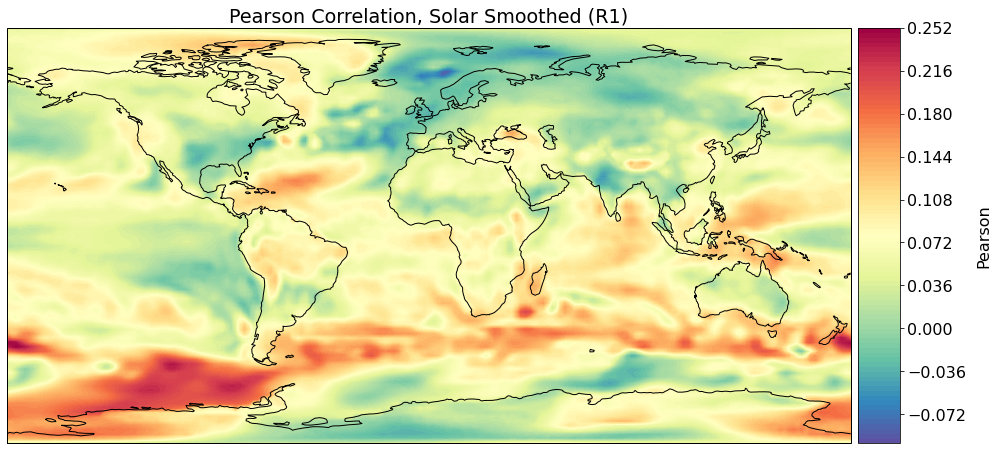

In [19]:
fig = plot_map(pears_coeff_smooth_full, title='Pearson Correlation, Solar Smoothed (R1)', colorbar_title='Pearson')
fig.savefig(path_results / 'map_smoothing_solar.png', dpi=300, bbox_inches='tight')
fig

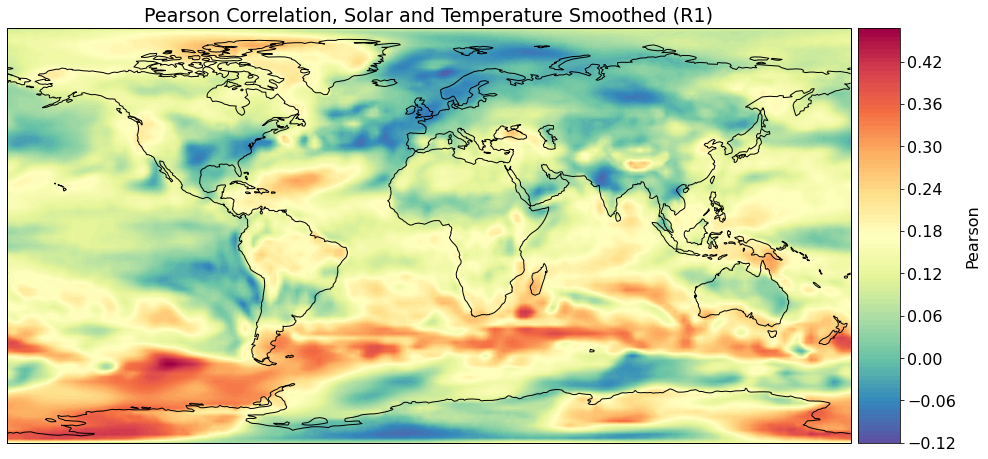

In [20]:
fig = plot_map(pears_coeff_doubleSmooth_full, title='Pearson Correlation, Solar and Temperature Smoothed (R1)', colorbar_title='Pearson')
fig.savefig(path_results / 'map_smoothing_solar-temp.png', dpi=300, bbox_inches='tight')
fig

c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


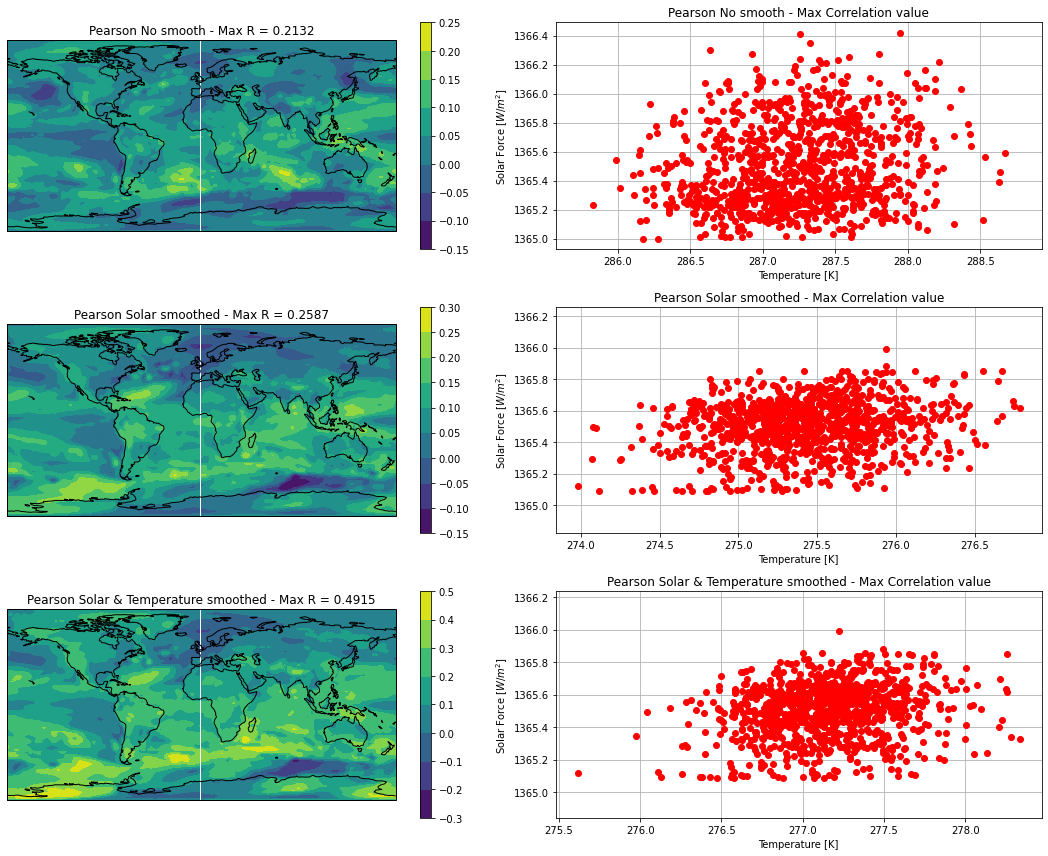

In [55]:
Visualize_pears_coeff(pears_coeff_train, pears_coeff_smooth_train, pears_coeff_doubleSmooth_train)

c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


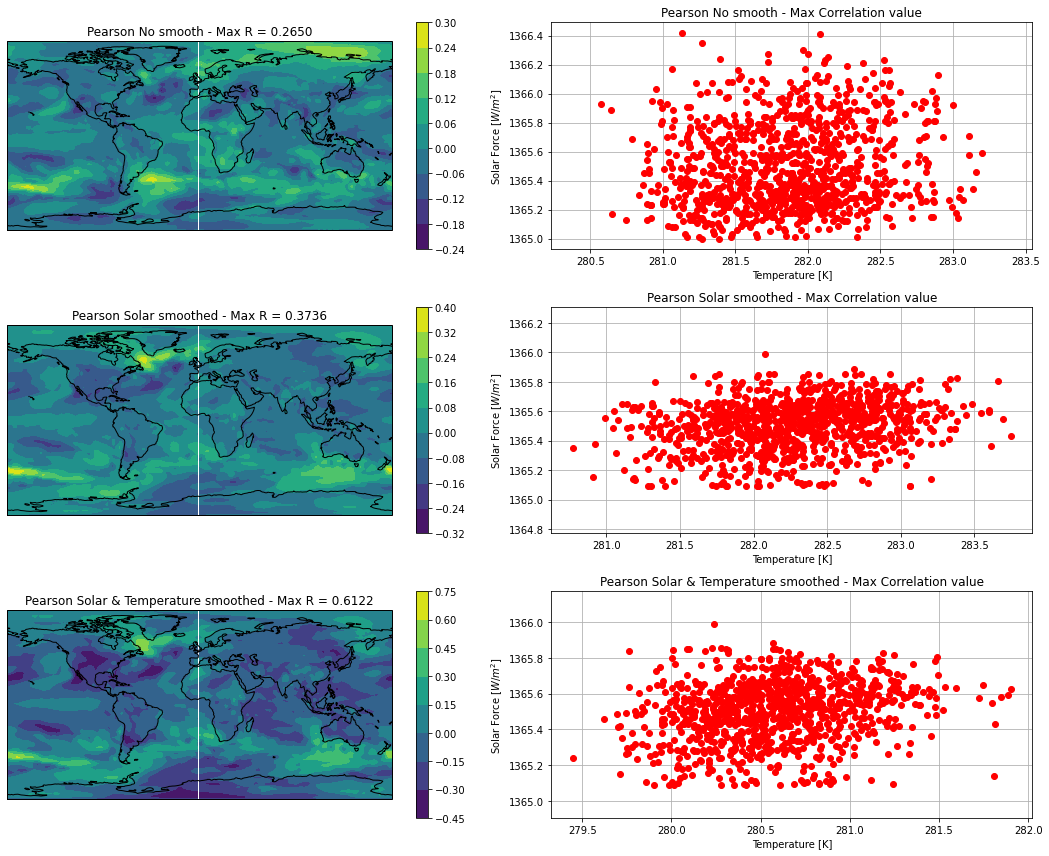

In [56]:
Visualize_pears_coeff(pears_coeff_test, pears_coeff_smooth_test, pears_coeff_doubleSmooth_test)

In [242]:
def visualize_temperature_over_time(Temperature, Pearson_coeff_map):
    boarder = np.max(Pearson_coeff_map.flatten()) - np.max(Pearson_coeff_map.flatten())*.05
    y_val = Temperature[:,Pearson_coeff_map>boarder]
    
    Nb_TimeSeries = y_val.shape[1]
    fig,ax = plt.subplots(Nb_TimeSeries, 1, figsize = (10,6))
    for i in range(0, Nb_TimeSeries):
        ax[i].plot(y_val[:,i])

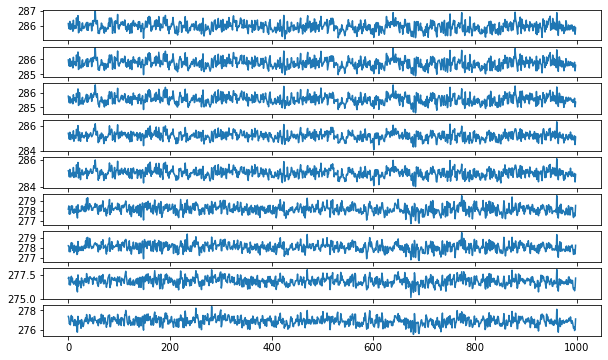

In [244]:
visualize_temperature_over_time(df_R1['T2m'], pears_coeff_full)

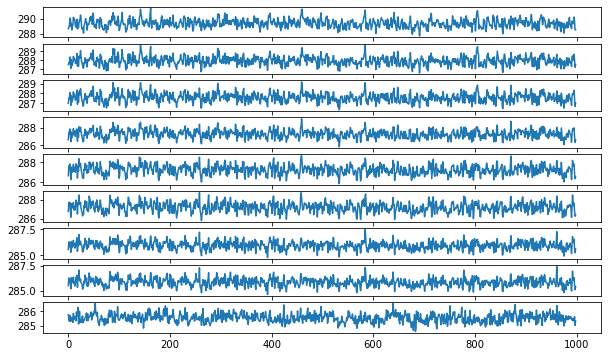

In [246]:
visualize_temperature_over_time(df_R1['T2m'], pears_coeff_train)

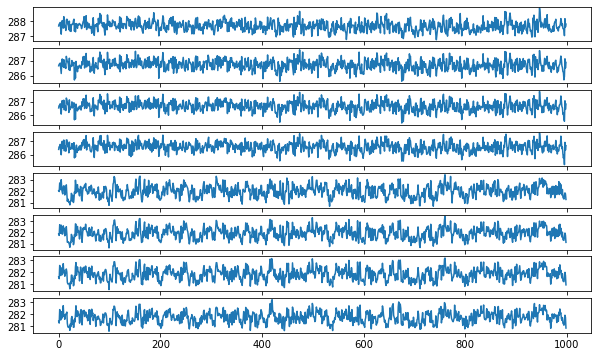

In [247]:
visualize_temperature_over_time(df_R1['T2m'], pears_coeff_test)

In [80]:
def Visualize_Mean_Temp(year_idx):
    
    Temperature=df_R1['T2m'] 
    Solar=df_solar['TSI']
    pears_coeff_smooth = np.zeros(shape = (Temperature.shape[1], Temperature.shape[2]))
    smooth_solar = Solar[year_idx:year_idx+100]
    #smooth_solar = smooth_butter(Solar,8)
    for i in range(Temperature.shape[1]):
        for j in range(Temperature.shape[2]):
            pears_coeff_smooth[i,j] = stats.pearsonr(Temperature[year_idx:year_idx+100,i,j], smooth_solar)[0]
    
    lats = df_R1['lat'][:]
    lons = df_R1['lon'][:]
    
    #Mean_Temp = np.std(Temperature,axis = 0)

    f = plt.figure(figsize=(14,10))
    #######################################################
    ## Pearson no smooth
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())
    pos1 = ax.contourf(lons, lats, pears_coeff_smooth, transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title('Pearson correlation between Temperature and Solar Force in the year span {} to {}'
                 .format(year_idx, year_idx+100))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Lattitude')
    f.colorbar(pos1, ax = ax)
    
year_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=900,
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [81]:
interact(Visualize_Mean_Temp, year_idx = year_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Year:', max=900), Output()), _d…

<function __main__.Visualize_Mean_Temp(year_idx)>

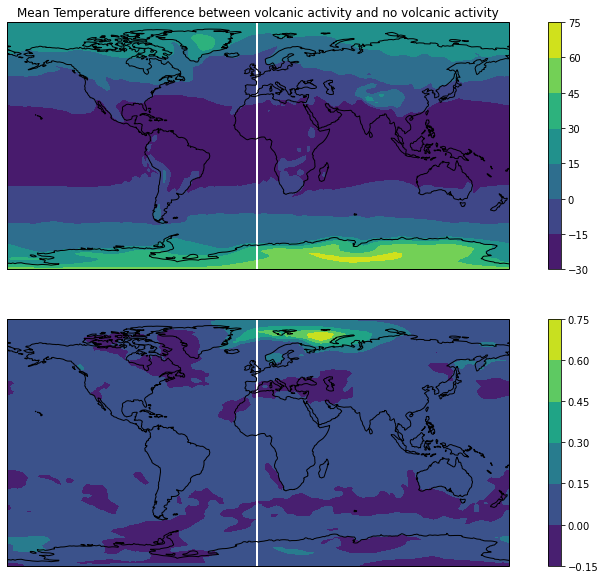

In [285]:
lats = df_R1['lat'][:]
lons = df_R1['lon'][:]

#Mean_Temp = np.mean(Temperature,axis = 0)
Mean_Temp2 = np.mean(df_R1['T2m'][df_volc['AOD'] > 0]) - np.mean(df_R1['T2m'][df_volc['AOD'] == 0],0)
Temp_diff = df_R1['T2m'][1:] - df_R1['T2m'][:-1]
Std_Temp2 = np.mean(Temp_diff[df_volc['AOD'][1:] == 0],0) - np.mean(Temp_diff[df_volc['AOD'][1:] > 0],0) 

f = plt.figure(figsize=(14,10))
#######################################################
## Pearson no smooth
ax = f.add_subplot(211, projection=ccrs.PlateCarree())
pos1 = ax.contourf(lons, lats, Mean_Temp2, transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Mean Temperature difference between volcanic activity and no volcanic activity')
ax.set_xlabel('Longitude')
ax.set_ylabel('Lattitude')
f.colorbar(pos1, ax = ax)

ax2 = f.add_subplot(212, projection=ccrs.PlateCarree())
pos2 = ax2.contourf(lons, lats, Std_Temp2, transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
ax2.coastlines()
f.colorbar(pos2, ax = ax2)

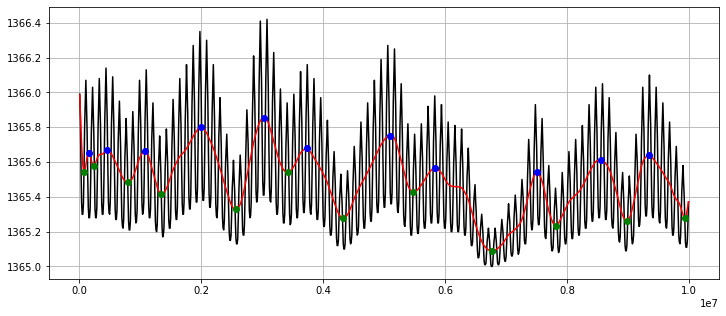

In [254]:
order = 8
smooth_solar = smooth_butter(df_solar['TSI'],order)
solar_smooth_maxX = df_solar['time'][signal.find_peaks(smooth_solar)[0]]
solar_smooth_maxY = smooth_solar[signal.find_peaks(smooth_butter(df_solar['TSI'],order))[0]]

solar_smooth_minX = df_solar['time'][signal.find_peaks(-1*smooth_solar)[0]]
solar_smooth_minY = smooth_solar[signal.find_peaks(smooth_butter(-1*df_solar['TSI'],order))[0]]
fig, ax = plt.subplots(1,1, figsize =(12,5))
ax.plot(df_solar['time'], df_solar['TSI'], 'k', label = 'Solar force');
ax.plot(df_solar['time'], smooth_butter(df_solar['TSI'],8), 'r', label = 'Solar force');
ax.plot(solar_smooth_maxX, solar_smooth_maxY, 'ob')
ax.plot(solar_smooth_minX, solar_smooth_minY, 'og')
ax.grid();

In [261]:
solar_smooth_minX.astype(int)

array([  80101,  240101,  800101, 1350101, 2570101, 3420101, 4330101,
       5480101, 6770101, 7820101, 8980101, 9930101])

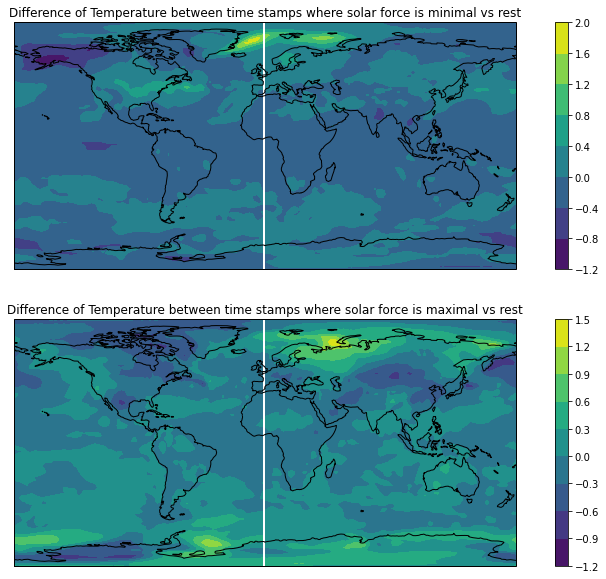

In [275]:
lats = df_R1['lat'][:]
lons = df_R1['lon'][:]

#Mean_Temp = np.mean(Temperature,axis = 0)
Mean_Temp_Solar_Min = np.mean(df_R1['T2m'][signal.find_peaks(-1*smooth_solar)[0]],0)
b = np.ma.array(df_R1['T2m'], mask=False)
b.mask[signal.find_peaks(-1*smooth_solar)[0]] = True
Mean_Temp_Solar_Diff = Mean_Temp_Solar_Min- np.mean(b,0)

Mean_Temp_Solar_Max = np.mean(df_R1['T2m'][signal.find_peaks(smooth_solar)[0]],0)
a = np.ma.array(df_R1['T2m'], mask=False)
a.mask[signal.find_peaks(smooth_solar)[0]] = True
Mean_Temp_Solar_Diff2 = Mean_Temp_Solar_Max - np.mean(a,0)

f = plt.figure(figsize=(14,10))
#######################################################
## Pearson no smooth
ax = f.add_subplot(211, projection=ccrs.PlateCarree())
pos1 = ax.contourf(lons, lats, Mean_Temp_Solar_Diff, transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Difference of Temperature between time stamps where solar force is minimal vs rest')
ax.set_xlabel('Longitude')
ax.set_ylabel('Lattitude')
f.colorbar(pos1, ax = ax)

#pears_coeff_doubleSmooth_full
ax2 = f.add_subplot(212, projection=ccrs.PlateCarree())
pos2 = ax2.contourf(lons, lats, Mean_Temp_Solar_Diff2, transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('Difference of Temperature between time stamps where solar force is maximal vs rest')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Lattitude')
f.colorbar(pos2, ax = ax2);

## Tensorflow Model

In [103]:
def reshape_data_window_approach(df, output, window_size, 
                                 step_size):

    labels = []
    data = []
    
    final_idx = df.shape[0] - window_size
    for i in range(0, df.shape[0], step_size):
        if i+window_size <= df.shape[0]:
            idx = range(i,i+window_size)
            
            #data.append(np.transpose(df[idx,:], (1,0)))
            data.append(df[idx,:])
            labels.append(np.reshape(output[idx],(window_size)))
    return np.array(data), np.array(labels)

def split_dataset(x, y, split_start, split_end):
    x_test = x[split_start:split_end]
    y_test = y[split_start:split_end]
    
    x_train = np.append(x[:split_start], x[split_end:], axis = 0)
    y_train = np.append(y[:split_start], y[split_end:], axis = 0)
    return x_train, x_test, y_train, y_test

def get_preprocessed_data(df_train, df_train_y, pears_coeff_map, time_enroll, step_size, k, test_size):
    # Find most correlated data between Solar Force and Temperature Model
    boarder = np.max(pears_coeff_map.flatten()) - np.max(pears_coeff_map.flatten())*.1
    df_R1_train = df_train[:,pears_coeff_map>boarder]
    # Split dataset
    x_data, x_validation, y_data, y_validation = split_dataset(df_R1_train, df_train_y, k*test_size, (k+1)*test_size)
    # Windowing dataset
    x_train, y_train = reshape_data_window_approach(x_data, y_data, time_enroll, step_size)
    x_val, y_val = reshape_data_window_approach(x_validation, y_validation, time_enroll, step_size)
        
    return x_train, x_val, x_val, y_val

In [330]:
# with test_size = 200 -> max k = 4 -> 5 K-fold CV
x_train, x_test, y_train, y_test = get_preprocessed_data(df_R1['T2m'], 
                                                         smooth_butter(df_solar['TSI'],8), 
                                                         pears_coeff_doubleSmooth_full,
                                                         time_enroll = 50, step_size = 1, k=4, test_size = 200)

print("x_train      = {}".format(x_train.shape))
print("y_train      = {}".format(y_train.shape))
print("x_test       = {}".format(x_test.shape))
print("y_test       = {}".format(y_test.shape))

x_train      = (751, 50, 16)
y_train      = (751, 50)
x_test       = (150, 50, 16)
y_test       = (150, 50)


In [331]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

#scaler_y = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_test_scaled = scaler.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

In [332]:
y_train_scaled.shape

(751, 50)

In [338]:
act = 'tanh'#'elu'# tanh
model = models.Sequential()
model.add(layers.Conv1D(16, (3), activation= act, input_shape=x_train_scaled.shape[1:], name = 'Inp'))
#model.add(layers.MaxPooling1D((2)))
model.add(layers.Conv1D(32, (3), activation= act, name = 'C1'))
#model.add(layers.MaxPooling1D((2)))
model.add(layers.Conv1D(16, (3), activation= act, name = 'C2'))
model.add(layers.MaxPooling1D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation= 'linear', name = 'D1'))
model.add(layers.Dense(y_train_scaled.shape[-1],activation = 'linear', name = 'Out'))



model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inp (Conv1D)                 (None, 48, 16)            784       
_________________________________________________________________
C1 (Conv1D)                  (None, 46, 32)            1568      
_________________________________________________________________
C2 (Conv1D)                  (None, 44, 16)            1552      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 22, 16)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 352)               0         
_________________________________________________________________
D1 (Dense)                   (None, 256)               90368     
_________________________________________________________________
Out (Dense)                  (None, 50)               

In [339]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
history = model.fit(x_train_scaled, y_train_scaled, epochs=30, shuffle = True, batch_size = 16,
                    validation_data=(x_test_scaled, y_test_scaled))

Train on 751 samples, validate on 150 samples
Epoch 1/30
751/751 [==============================] - 2s 2ms/sample - loss: 0.7058 - val_loss: 0.6106
Epoch 2/30
751/751 [==============================] - 1s 975us/sample - loss: 0.5790 - val_loss: 0.6589
Epoch 3/30
751/751 [==============================] - 1s 925us/sample - loss: 0.4662 - val_loss: 0.6715
Epoch 4/30
751/751 [==============================] - 1s 1ms/sample - loss: 0.3549 - val_loss: 0.5759
Epoch 5/30
751/751 [==============================] - 1s 1ms/sample - loss: 0.2763 - val_loss: 0.5413
Epoch 6/30
751/751 [==============================] - 1s 956us/sample - loss: 0.2281 - val_loss: 0.5080
Epoch 7/30
751/751 [==============================] - 1s 1ms/sample - loss: 0.2098 - val_loss: 0.4923
Epoch 8/30
751/751 [==============================] - 1s 910us/sample - loss: 0.1678 - val_loss: 0.5058
Epoch 9/30
751/751 [==============================] - ETA: 0s - loss: 0.147 - 1s 1ms/sample - loss: 0.1461 - val_loss: 0.4944
Epoc

In [340]:
preds = model.predict(x_test_scaled)
y_rescale_pred = scaler.inverse_transform(preds)

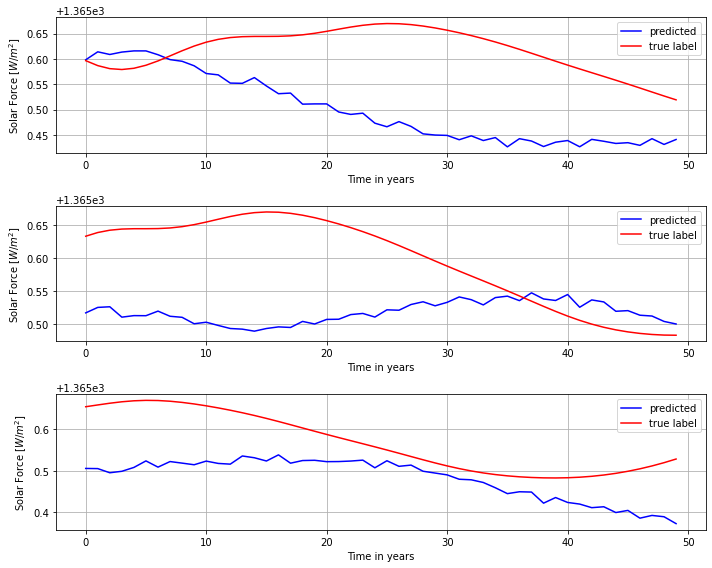

In [347]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
for i, idx in enumerate(range(20,50,10)):
    ax[i].plot(y_rescale_pred[idx],'b',label='predicted')
    ax[i].plot(y_train[idx],'r', label ='true label')
    ax[i].legend()
    ax[i].set_ylabel(r'Solar Force $[W/m^2]$')
    ax[i].set_xlabel('Time in years')
    ax[i].grid()
    #ax[i].plot(preds[idx]);
fig.tight_layout()
fig.savefig('../results/Regression_result.png', dpi=300, bbox_inches='tight')